### Training a corpus-wide RMN with tfidf embeddings

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append("/home/rocassius/w266_final/scripts/assembly")
sys.path.append("/home/rocassius/w266_final/scripts/modeling")

In [3]:
from document import load_documents
from constant import DOC_PRAYER_PATH, MIN_SESSION, MAX_SESSION, DOC_ALL_PATH
from subject import subject_keywords

sessions = list(range(MIN_SESSION, MAX_SESSION+1))

In [4]:
from helper import *
from rmn import *
from rmn_data_generator import RMN_DataGenerator
from rmn_analyzer import RMN_Analyzer

In [5]:
# load embedding tools
prayer_tools_path = "/home/rocassius/gen-data/tools/prayer_tools"
metadata_dict = load_pickled_object(os.path.join(prayer_tools_path, "metadata_dict"))
tokenizer_dict = load_pickled_object(os.path.join(prayer_tools_path, "tokenizer_dict"))
embedding_matrix = load_pickled_object(os.path.join(prayer_tools_path, "idf_embedding_matrix"))
global_embedding_matrix = load_pickled_object(os.path.join(prayer_tools_path, "embedding_matrix_wg"))
global_tokenizer_dict = load_pickled_object(os.path.join(prayer_tools_path, "tokenizer_dict_wg"))

In [6]:
docs_df = load_documents([66], DOC_PRAYER_PATH)

In [7]:
data_df = docs_df.sample(2347)

In [8]:
docs_df.shape

(35475, 10)

In [9]:
local_models_path = "/home/rocassius/gen-data/models"

In [10]:
rmn = RigidRMN()
rmn.load_rmn("SuaveRanger", local_models_path)
rmn.infer_embedding_matrix = global_embedding_matrix
rmn.infer_tokenizer_dict = global_tokenizer_dict

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
# def mean_pair_similarity(vectors):
    
#     n_vec = vectors.shape[0]
#     index_A = np.tile(range(n_vec), n_vec)
#     index_B = np.repeat(range(n_vec), n_vec)
    
#     v_A, v_B = vectors[index_A], vectors[index_B]
#     norm = (np.linalg.norm(v_A, axis=1) * 
#             np.linalg.norm(v_B, axis=1))
#     sim = (v_A * v_B).sum(axis=1) / norm
    
#     coherence = (sim.sum() - n_vec) / (n_vec**2 - n_vec)
    
#     return coherence
    
    
# def vector_coherence(index, W):    
#     return mean_pair_similarity(W[index])
    

# def word_coherence(words, word_index, W):
#     return vector_coherence([word_index[w] for w in words], W)


# def random_coherence(k, W):
    
#     v = np.random.uniform(low=-1., high=1., size=W.shape[1])
#     nn, sim = find_nn_cos(v, W, k)    
#     nn_coherence = vector_coherence(nn, W)
    
#     return nn_coherence

In [12]:
# #====================#
# #=*= RMN Analyzer =*=#
# #====================#

# # Class for analyzing an RMN

# import numpy as np
# import pandas as pd
# from analysis import *

# # variable constants
# SUB = 'subject'
# SPEAK = 'speakerid'
# PARTY = 'party'
# SESS = 'session'
# # party constants
# R = 'R'
# D = 'D'
# # metric constants
# JS = 'js'
# HH = 'hh'
# EN = 'entr'
# N_REC = 'n_records'
# N_NAN = 'n_nan_preds'
# TP = 'topic_use'


# class RMN_Analyzer(object):
#     """Class for Analyzing an RMN with respect to a dataset
#     """
    
#     def __init__(self, rmn, df):
#         """
#         Args:
#         - rmn: (RMN) the RMN to be used for analysis
#         - df : (DataFrame) the dataframe to analyze
#         """
        
#         'Initialization'
#         self.rmn = rmn
#         self.df = df.reset_index(drop=True)
#         self.topic_preds = None
#         self.y_preds = None
        
#         self.topic_nns = None
#         self.topic_coherence = None
        
        
#     @property
#     def index(self):
#         return self.df.index
        
    
#     def predict_topics(self, use_generator=True):
#         """Computes the topic predictions for all observations
#         """
#         self.topic_preds = self.rmn.predict_topics(self.df, use_generator)
        
    
#     def predict_y(self, use_generator=True):
#         """Computes the sentence vector predictions for all observations
#         """
#         self.y_preds = self.rmn.predict_y(self.df, use_generator)
        
        
#     def sample_indices(self, indices, n):
#         """Returns a SRR of the indices provided
#         """
#         return np.random.choice(indices, n, replace=True)

    
#     def bool_subset(self, col, value):
#         """
#         Returns a boolean vector for each observation in the
#         dataframe indicating whether it meets the col == value condition
#         """
#         assert col in self.df.columns
#         return self.df[col] == value
    
    
#     def bool_index(self, conditions):
#         """
#         Returns a boolean vector for each observation in the
#         dataframe indicating whether it meets all conditions
        
#         Args:
#         - conditions: (dict) dictionary of conditions
        
#         Returns: 
#         - pandas series of booleans indicating where all 
#           of the conditions hold
#         """
#         # initialize bool index
#         bool_index = (pd.Series(True)
#                       .repeat(self.index.shape[0])
#                       .reset_index(drop=True))
        
#         for col, val in conditions.items():
#             bool_index = bool_index & self.bool_subset(col, val)
            
#         return bool_index
    
    
#     def cond_index(self, conditions):
#         """Returns indices of records meeting the conditions
#         """
#         return self.index[self.bool_index(conditions)]
    
    
#     def n_records(self, conditions={}):
#         """Returns the number of records meetings the conditions
#         """
#         return len(self.cond_index(conditions))
    
    
#     def n_nan_preds(self, conditions={}):
#         """Returns the number of records which have nan predictions
#         """
#         cond_index = self.cond_index(conditions)
#         return np.isnan(self.topic_preds[cond_index].sum(axis=-1)).sum().item()
    
    
#     def compute_JS(self, index_A, index_B, base=2):
#         """
#         Computes the mean pair-wise JS divergence and associated CI
#         between indices in index_A and indices in index_B
#         """
#         p_A = self.topic_preds[index_A]
#         p_B = self.topic_preds[index_B]
#         js_list = [jensenshannon(p, q, base) for p, q in zip(p_A, p_B)]
        
#         return mean_CI(js_list)
        
        
#     def compute_HH(self, index):
#         """
#         Computes the mean HH index and associated CI between
#         indices in index_A and indices in index_B
#         """
#         p = self.topic_preds[index]
#         hh_list = [hh_index(q) for q in p]
        
#         return mean_CI(hh_list)
    
    
#     def topic_use_RD_js(self, conditions={}):
#         """Returns the JS divergence of the R and D topic use distributions
#         """
#         R_topic_use = self.topic_use({**conditions, **{PARTY: R}})
#         D_topic_use = self.topic_use({**conditions, **{PARTY: D}})
        
#         return jensenshannon(R_topic_use, D_topic_use)
    
    
#     def topic_use_hh(self, conditions={}):
#         """Returns the HH-index of the RD topic use distributions
#         """
#         return hh_index(self.topic_use(conditions))
    
    
#     def inter_party_js(self, conditions, n):
#         """
#         Returns the estimated inter party JS divergence and a CI.
        
#         Computes the inter party JS divergence between 
#         Republicans and Democrats on a given subject
        
#         Args:
#         - subject: (str) subject to examine
#         - n      : (int) sample size
        
#         Returns: a numpy array of length 3, where
#         - 0 is the mean divergence point estimate:
#         - 1 is the lower bound of a 95% CI
#         - 2 is the upper bound of a 95% CI
#         """
#         # ensure that the topic predictions exist
#         if self.topic_preds is None:
#             self.predict_topics()
        
#         # find R and D indicies on the subject
#         index_R = self.cond_index({**conditions, **{PARTY: R}})
#         index_D = self.cond_index({**conditions, **{PARTY: D}})
        
#         # return None if indices are insufficient
#         if len(index_R)==0 or len(index_D)==0:
#             return None
        
#         # sample 
#         samp_index_R = self.sample_indices(index_R, n)
#         samp_index_D = self.sample_indices(index_D, n)
    
#         return self.compute_JS(samp_index_R, samp_index_D)
    
    
#     def group_js(self, conditions, n):
#         """
#         Returns the estimated mean JS divergence and a CI
        
#         Estimates the average JS divergence between any two documents of
#         a group defined by the conditions. A document by speaker _i_ is 
#         never compared to another document by speaker _i_.
        
        
#         Args:
#         - conditions: (dict) dictionary of conditions
#         - n         : (int) sample size
        
#         Returns: a numpy array of length 3, where index...
#         - 0 is the mean divergence point estimate:
#         - 1 is the lower bound of a 95% CI
#         - 2 is the upper bound of a 95% CI
#         """
#         # ensure that the topic predictions exist
#         if self.topic_preds is None:
#             self.predict_topics()
        
#         # find indicies of party on the subject
#         cond_index = self.cond_index(conditions)
        
#         # Return none if there are fewer than 2 speakers
#         if self.df.loc[cond_index][SPEAK].nunique() < 2:
#             return None
        
#         # Sample index pairs
#         index_AB = []
#         while len(index_AB) < n:
#             a_b = self.sample_indices(cond_index, n=2)
#             # include samples whose speakers are different
#             if self.df.loc[a_b][SPEAK].nunique() == 2:
#                 index_AB.append(a_b)
        
#         index_AB = np.asarray(index_AB)
#         assert index_AB.shape == (n, 2)
        
#         # get indices for each group
#         index_A, index_B = index_AB[:,0], index_AB[:,1]
        
#         return self.compute_JS(index_A, index_B)
    
    
#     def group_hh(self, conditions={}, n=None):
#         """
#         Returns the estimated mean HH index and a CI
        
#         Estimates the average Herfindahl–Hirschman Index 
#         of all records meetings the conditons.
        
#         Args:
#         - subject: (str) subject to examine
#         - party  : (str) party of interest
#         - n      : (int) sample size
        
#         Returns: a numpy array of length 3, where index...
#         - 0 is the mean index point estimate:
#         - 1 is the lower bound of a 95% CI
#         - 2 is the upper bound of a 95% CI
#         """
#         # ensure that the topic predictions exist
#         if self.topic_preds is None:
#             self.predict_topics()
        
#         # indicies meeting the conditions
#         cond_index = self.cond_index(conditions)
        
#         # return None if indices are insufficient
#         if len(cond_index)==0:
#             return None
        
#         if n is None:
#             return self.compute_HH(cond_index)
#         else:
#             samp_index = self.sample_indices(cond_index, n)
#             return self.compute_HH(samp_index)
        
        
#     def analyze_subset(self, conditions, n):
#         """
#         Returns a dictionary of analysis metrics for the subset 
#         of records defined by the conditions.
        
#         Note: It is recommended conditions be on subject
        
#         Args:
#         - conditions: (dict) dictionary of conditions
#         - n         : (int) sample size for estimation of metrics
        
#         for the entire dataset and for each subject the following are computed:
#         - n_records, n_records_R
#         - n_records_D
#         - js
#         - js_R
#         - js_D
#         - js_RD
#         - hh
#         - hh_R
#         - hh_D
        
#         Returns: a dictionary of metrics
#         """
#         # R and D added conditions
#         conditions_R = {**conditions, **{PARTY: R}}
#         conditions_D = {**conditions, **{PARTY: D}}
        
#         # annotation tags
#         _R = '_' + R
#         _D = '_' + D
#         _RD = _R + D
#         _TP = '_' + TP
        
#         metrics = {
#             # n records in data
#             N_REC:    self.n_records(conditions),
#             N_REC+_R: self.n_records(conditions_R),
#             N_REC+_D: self.n_records(conditions_D),
#             N_NAN+_R: self.n_nan_preds(conditions_R),
#             N_NAN+_D: self.n_nan_preds(conditions_D),
#             # JS divergence data
#             JS:     self.group_js(conditions, n),
#             JS+_R:  self.group_js(conditions_R, n),
#             JS+_D:  self.group_js(conditions_D, n),
#             JS+_RD: self.inter_party_js(conditions, n),
#             # HH index data
#             HH:    self.group_hh(conditions, n),
#             HH+_R: self.group_hh(conditions_R, n),
#             HH+_D: self.group_hh(conditions_D, n),
#             # Topic Use Metrics
#             HH+_TP:    self.topic_use_hh(conditions),
#             HH+_TP+_R: self.topic_use_hh(conditions_R),
#             HH+_TP+_D: self.topic_use_hh(conditions_D),
#             JS+_TP:    self.topic_use_RD_js(conditions),
#         }
        
#         return metrics
    
        
#     def analyze(self, subjects, n):
#         """
#         Returns a dictionary of analysis metrics at the subject level
#         and at the session level (assuming self.df is the data of a
#         single session).
        
#         Args:
#         - subjects: (array-like) list of subjects
#         - n       : (int) sample size for estimation of metrics
        
#         Returns: a dictionary of metrics
#         """
#         # analyze entire session dataset
#         dataset_metrics = self.analyze_subset(conditions={}, n=n)
        
#         # analyze by subject
#         subject_metrics = {}
#         for s in subjects:
#             subject_metrics[s] = self.analyze_subset({SUB: s}, n)
        
#         metrics = {'dataset' : dataset_metrics, 
#                    'subjects': subject_metrics}
        
#         return metrics
    
    
#     def shannon_entropy(self, conditions={}):
#         """Returns the Shannon Entropy of topic predictions meeting conditions
#         """
#         # ensure that the topic predictions exist
#         if self.topic_preds is None:
#             self.predict_topics()
        
#         return shannon_entropy(self.topic_preds[self.cond_index(conditions)])
    
    
#     def mean_entropy(self, conditions={}):
#         """Returns the mean entropy of topic predictions meeting condiditons
#         """
#         return np.nanmean(self.shannon_entropy(conditions))
        
    
#     def first_topic_counts(self, conditions={}):
#         """
#         Returns a leaderboard of topics and how many times they 
#         are the primary topic associated with a document.
#         """
#         if self.topic_preds is None:
#             self.predict_topics()
           
#         cond_index = self.cond_index(conditions)
#         topic_counts = pd.Series(np.argmax(self.topic_preds[cond_index], axis=-1)).value_counts()
        
#         return topic_counts
    
    
#     def topic_use(self, conditions={}):
#         """
#         Returns a leaderboard of topics based on the percentage of 
#         total weight given to them in all of the documents
#         """
#         cond_index = self.cond_index(conditions)
#         topic_sums = pd.Series(np.nansum(self.topic_preds[cond_index], axis=0))
#         topic_use = topic_sums.sort_values(ascending=False) / topic_sums.sum()
        
#         return topic_use
    
    
#     def primary_topics(self, conditions={}, k=5):
#         """Returns top k most prominent topics for documents
#         """
#         cond_index = self.cond_index(conditions)
#         primary_topics = np.flip(np.argsort(self.topic_preds[cond_index]), axis=-1)[:,:k]
        
#         return primary_topics
    
    
#     def find_topic_nns(self):
#         """Finds the nearest neighbors of the rmn's topics
#         """
#         self.topic_nns = np.array(rmn.inspect_topics())
      
    
#     def find_topic_coherence(self, k=5):
#         """Updates the topic coherence scores of the 
#         """
#         W = self.rmn.infer_embedding_matrix
#         word_index = self.rmn.infer_tokenizer_dict['word_index']
#         coherence_scores = [word_coherence(np.array(t)[:5,0], word_index, W) 
#                             for t in self.topic_nns]
        
#         self.topic_coherence = pd.Series(coherence_scores).sort_values(ascending=False)
        
    
#     @property
#     def topic_nn_sim(self):
#         return pd.Series(self.topic_nns[:,0,1]).sort_values(ascending=False)
        

In [87]:
data_df

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session
24122,66079650,GLYNN,JAMES,H,CT,M,R,similar cases occur among members of the house...,foreign,66
12310,66075430,CAMPBELL,PHILIP,H,KS,M,R,delay he says we should have more information ...,economy,66
24221,66075840,HUSTED,JAMES,H,NY,M,R,check up what we have done i am sure the would...,foreign,66
12283,66084501,KING,WILLIAM,S,UT,M,D,over the public highways it is estimated that ...,economy,66
18128,66078171,SIMMONS,FURNIFOLD,S,NC,M,D,authorized by the federal reserve board i thin...,foreign,66
...,...,...,...,...,...,...,...,...,...,...
23277,66076130,MANN,JAMES,H,IL,M,R,president i have discussed this budget questio...,foreign,66
13170,66074100,CALDWELL,CHARLES,H,NY,M,D,escape the intolerable conditions of their own...,education,66
5381,66078500,BLACK,EUGENE,H,TX,M,D,amendment i read that the act approved october...,defense,66
34727,66073411,MCCUMBER,PORTER,S,ND,M,R,smaller in area than the state of indianaexerc...,trade,66


In [12]:
analyzer = RMN_Analyzer(rmn, data_df)

In [13]:
analyzer.predict_topics()

In [37]:
# analyzer.find_topic_nns()
# nns = analyzer.topic_nns
# analyzer.topic_nns = np.array(nns)

In [38]:
analyzer.find_topic_coherence()

In [39]:
np.mean(analyzer.topic_coherence)

0.6701718750000002

In [40]:
np.std(analyzer.topic_coherence)

0.08869908585792331

In [41]:
analyzer.topic_coherence[45:50]

34    0.542188
8     0.512109
5     0.484766
24    0.478906
2     0.474219
dtype: float64

In [42]:
#analyzer.topic_nns[analyzer.topic_coherence.index[:5]][:,:,0]

In [43]:
analyzer.topic_nns[analyzer.topic_coherence.index[45:50]][:,:,0]

array([['violate', 'applicable', 'precedent', 'violation', 'applies',
        'limitation', 'laws', 'regard', 'unfair', 'certain'],
       ['e', 'page', 'k', 'w', 'text', 'n', 'article', 'letter', 'note',
        'h'],
       ['drink', 'amount', 'liquid', 'amounts', 'soda', 'concoction',
        'excess', 'ingredients', 'ingredient', 'essence'],
       ['exacerbated', 'unnecessarily', 'inevitable', 'embarrassing',
        'embarrassment', 'unfortunate', 'fear', 'unnecessary', 'vicious',
        'intolerable'],
       ['territories', 'lands', 'granted', 'abolished', 'legally',
        'privileges', 'permitted', 'governed', 'territory', 'permit']],
      dtype='<U14')

In [44]:
analyzer.topic_nn_sim

3     0.928
41    0.909
37    0.904
21    0.895
47    0.892
11    0.883
43    0.882
18    0.879
31    0.878
49    0.878
19    0.877
40    0.864
16    0.861
20    0.857
17    0.857
6     0.851
42    0.851
22    0.849
48    0.849
45    0.839
27    0.829
23    0.826
35    0.823
4     0.822
32    0.819
26    0.815
44    0.813
30    0.812
39    0.811
7      0.81
29    0.807
9     0.803
46    0.782
25    0.765
15    0.764
10    0.764
12    0.759
33    0.751
36    0.749
38    0.743
13    0.727
8     0.718
34    0.711
24    0.694
0     0.686
14    0.684
2     0.664
1     0.633
28    0.609
5     0.598
dtype: object

In [45]:
analyzer.predict_topics()

10/10 [==============================] - 0s 41ms/step


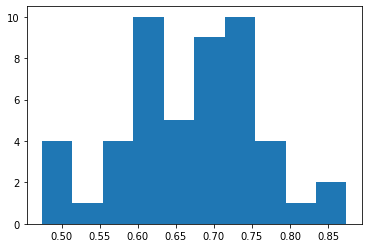

In [46]:
plt.hist(analyzer.topic_coherence)
plt.show()# topic_coherences

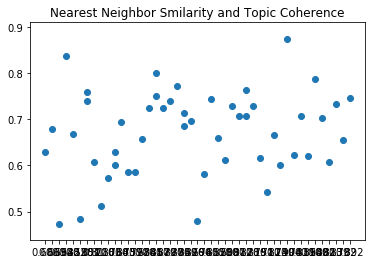

In [47]:

plt.scatter(analyzer.topic_nn_sim.sort_index(), analyzer.topic_coherence.sort_index())
plt.title("Nearest Neighbor Smilarity and Topic Coherence")
plt.show()

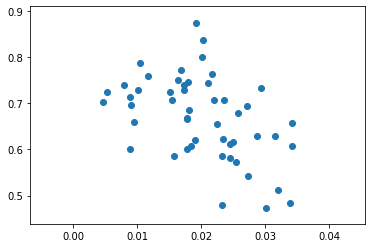

In [52]:
plt.scatter(analyzer.topic_use().sort_index(), analyzer.topic_coherence.sort_index())
plt.show()

In [49]:
from scipy.stats import linregress

In [50]:
linregress(analyzer.topic_coherence.sort_index(), analyzer.topic_use().sort_index())

LinregressResult(slope=-0.04104871924468703, intercept=0.047509696695525655, rvalue=-0.4775383655243361, pvalue=0.00045351245824553043, stderr=0.010901024347022479)

In [284]:
analyzer.topic_nns[analyzer.topic_use().index[:10]]

array([[['cannot', '0.684'],
        ['resolved', '0.663'],
        ['decide', '0.662'],
        ['determined', '0.658'],
        ['proceed', '0.653'],
        ['whether', '0.651'],
        ['confirm', '0.651'],
        ['definitively', '0.647'],
        ['determine', '0.645'],
        ['convinced', '0.637']],

       [['drink', '0.598'],
        ['amount', '0.573'],
        ['liquid', '0.571'],
        ['amounts', '0.566'],
        ['soda', '0.566'],
        ['concoction', '0.566'],
        ['excess', '0.566'],
        ['ingredients', '0.566'],
        ['ingredient', '0.565'],
        ['essence', '0.557']],

       [['navy', '0.883'],
        ['naval', '0.834'],
        ['command', '0.818'],
        ['fleet', '0.806'],
        ['corps', '0.802'],
        ['squadron', '0.797'],
        ['battalion', '0.773'],
        ['commanded', '0.773'],
        ['marines', '0.77'],
        ['infantry', '0.765']],

       [['necessary', '0.686'],
        ['adequate', '0.677'],
        ['appropriate'

In [286]:
analyzer.topic_coherence.mean()

0.6701718750000002

In [15]:
W = analyzer.rmn.infer_embedding_matrix
# random_coherences = [random_coherence(5, W) for _ in range(1000)]

(array([ 67., 375., 351., 138.,  47.,  14.,   3.,   4.,   0.,   1.]),
 array([0.06738281, 0.15759766, 0.2478125 , 0.33802734, 0.42824219,
        0.51845703, 0.60867187, 0.69888672, 0.78910156, 0.87931641,
        0.96953125]),
 <a list of 10 Patch objects>)

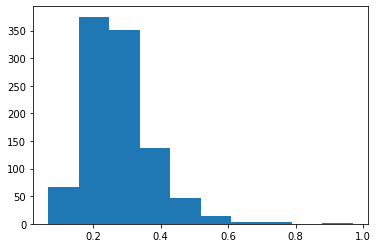

In [20]:
plt.hist(random_coherences)

In [29]:
m = np.mean(random_coherences)

In [30]:
s = np.std(random_coherences)

In [31]:
m+ 2*s

0.47162352798083884

In [32]:
np.quantile(random_coherences, 0.95)

0.4558984375

In [18]:
from analysis import *

In [19]:
# def random_coherence(k, W):
    
#     v = np.random.uniform(low=-1., high=1., size=W.shape[1])
#     nn, sim = find_nn_cos(v, W, k)    
#     nn_coherence = vector_coherence(nn, W)
    
#     return nn_coherence  

In [22]:
for _ in range(4):
    v = np.random.uniform(low=-1., high=1., size=W.shape[1])
    nn, sim = find_nn_cos(v, W, 5)    
    nn_coherence = vector_coherence(nn, W)
    
    words = [analyzer.rmn.infer_tokenizer_dict['tokenizer'].index_word[n] for n in nn] 
    print(words)
    print(nn_coherence)

['riddle', 'stockton', 'keun', 'kersee', 'duluth']
0.21796875
['stamps', 'reauthorize', 'enema', 'appropriation', 'physiotherapy']
0.228515625
['fabriclive', 'exceptionalism', 'adobo', 'reaganesque', 's400']
0.3046875
['belleza', 'witz', 'dyfi', 'qiantang', 'tropospheric']
0.222265625


In [6]:
df = load_documents([108, 109, 110, 111], DOC_PRAYER_PATH)

In [7]:
df

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session
0,108119160,DEFAZIO,PETER,H,OR,M,D,the mother so if there are no cases where it i...,abortion,108
1,108116401,INOUYE,DANIEL,S,HI,M,D,that is being bandied about it would not be di...,abortion,108
2,108119920,JACKSON LEE,SHEILA,H,TX,F,D,president i rise with chafee to introduce a bi...,abortion,108
3,108113881,STEVENS,TED,S,AK,M,R,decades they fear about the supreme court and ...,abortion,108
4,108112971,DEWINE,MICHAEL,S,OH,M,R,across the nation who are worried about their ...,abortion,108
...,...,...,...,...,...,...,...,...,...,...
92749,111120531,MIKULSKI,BARBARA,S,MD,F,D,of a more accurate food facility registry impr...,trade,111
92750,111120170,LATTA,ROBERT,H,OH,M,R,their lives to save others that day these meda...,trade,111
92751,111116441,HUTCHISON,KAY,S,TX,F,R,investment this year the development assistanc...,trade,111
92752,111120860,POLIS,JARED,H,CO,M,D,economytoo much in the last decade of folks pa...,trade,111


In [26]:
# df_match = 
df = df[(df['speakerid']=='108119920') | (df['speakerid']=='108113881')]
#df = df[df['speakerid']=='108119920']

In [27]:
analyzer = RMN_Analyzer(rmn, df)

In [28]:
analyzer.predict_topics()

In [29]:
# preds = analyzer.topic_preds

In [32]:
np.sum(preds != analyzer.topic_preds[analyzer.cond_index({'speakerid': '108119920'})])

0

In [133]:
c = analyzer.topic_preds

In [134]:
c.sum()

793.99994

In [135]:
c = (preds != analyzer.topic_preds)

In [137]:
c.sum() / 100

79.0

In [124]:
# preds = analyzer.topic_preds
preds.shape

(794, 50)

In [109]:
analyzer.df['subject'].unique()

array(['abortion', 'drug_alcohol', 'budget', 'guns', 'defense', 'economy',
       'education', 'foreign', 'health', 'immigration', 'labor',
       'minorities', 'women', 'tax', 'trade'], dtype=object)

In [110]:
analyzer.find_topic_nns()

/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: divide by zero encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))
/home/rocassius/w266_final/scripts/modeling/vector_math.py:34: RuntimeWarning: invalid value encountered in true_divide
  Ds = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis = 1))



Topic 0
['necessary', 'adequate', 'appropriate', 'useful', 'properly', 'efficiently', 'utilize', 'tasks', 'providing', 'provide']


KeyboardInterrupt: 

In [112]:
analyzer.df

,speakerid,lastname,firstname,chamber,state,gender,party,document,subject,session
0,108119920,JACKSON LEE,SHEILA,H,TX,F,D,president i rise with chafee to introduce a bi...,abortion,108
1,108119920,JACKSON LEE,SHEILA,H,TX,F,D,rise in opposition to the amendment to s that...,abortion,108
2,108119920,JACKSON LEE,SHEILA,H,TX,F,D,misuse of the filibuster they criticize kuhls ...,abortion,108
3,108119920,JACKSON LEE,SHEILA,H,TX,F,D,name three supreme court cases in the last ye...,abortion,108
4,108119920,JACKSON LEE,SHEILA,H,TX,F,D,i am suggesting to my friend that when people ...,abortion,108
...,...,...,...,...,...,...,...,...,...,...
789,108119920,JACKSON LEE,SHEILA,H,TX,F,D,instructions for overseas assignments delaying...,trade,108
790,108119920,JACKSON LEE,SHEILA,H,TX,F,D,of maintaining it dlindjic was an effective de...,trade,108
791,108119920,JACKSON LEE,SHEILA,H,TX,F,D,health and the environment given the concern m...,trade,108
792,108119920,JACKSON LEE,SHEILA,H,TX,F,D,a runner on second with the tying run at the p...,trade,108


In [111]:
analyzer.topic_use({'subject': 'abortion'})

38    0.139428
16    0.103645
25    0.086492
47    0.079346
3     0.067411
37    0.065845
14    0.061035
39    0.054541
30    0.038324
21    0.037176
28    0.027588
33    0.027135
1     0.022511
36    0.016015
31    0.015899
15    0.015148
34    0.013880
17    0.013132
19    0.010763
5     0.009732
46    0.009285
45    0.008042
8     0.007683
7     0.007037
2     0.006866
10    0.006223
24    0.006133
49    0.005905
27    0.004030
32    0.004025
18    0.003703
23    0.002937
0     0.002914
40    0.002716
9     0.002645
29    0.002078
41    0.001938
13    0.001802
48    0.001601
35    0.001272
43    0.001117
26    0.001099
12    0.001034
42    0.000709
11    0.000669
6     0.000594
20    0.000456
4     0.000218
22    0.000141
44    0.000080
dtype: float32

In [113]:
analyzer.topic_nns[[38,16,25]]

TypeError: 'NoneType' object is not subscriptable

In [104]:
analyzer.topic_use({'speakerid': '108119920', 'subject': 'abortion'})

21    0.126599
16    0.103379
34    0.096589
14    0.086058
30    0.082578
33    0.077941
39    0.044387
28    0.044259
38    0.043068
1     0.042469
25    0.037454
37    0.024855
8     0.023814
2     0.022185
5     0.018318
3     0.014073
32    0.013723
17    0.012022
24    0.009163
47    0.009160
36    0.008421
45    0.006835
10    0.006075
0     0.005956
15    0.005160
31    0.004550
19    0.004501
43    0.003732
7     0.003582
4     0.002698
46    0.002683
27    0.002366
49    0.001881
48    0.001456
29    0.001203
18    0.001001
13    0.000730
26    0.000709
40    0.000652
42    0.000619
41    0.000582
23    0.000543
9     0.000538
12    0.000489
6     0.000305
20    0.000270
35    0.000117
11    0.000089
22    0.000083
44    0.000078
dtype: float32

In [105]:
analyzer.topic_use({'speakerid': '108113881', 'subject': 'abortion'})

21    0.242749
25    0.111155
16    0.091975
23    0.088045
34    0.080668
33    0.070566
49    0.069137
7     0.038396
19    0.027475
3     0.025134
47    0.016292
15    0.014350
43    0.012503
17    0.012231
32    0.012097
37    0.011407
24    0.009759
39    0.009397
40    0.007582
30    0.007210
10    0.005959
29    0.003964
27    0.003846
46    0.003406
14    0.003166
42    0.002327
31    0.002198
38    0.001644
9     0.001473
13    0.001378
12    0.001264
35    0.001129
18    0.001100
28    0.001044
8     0.001038
6     0.001027
36    0.000987
41    0.000981
45    0.000734
48    0.000632
0     0.000596
20    0.000524
4     0.000327
26    0.000275
2     0.000267
5     0.000179
11    0.000152
22    0.000143
44    0.000092
1     0.000019
dtype: float32

In [103]:
analyzer.topic_nns[analyzer.topic_use({'speakerid': '108113881', 'subject': 'abortion'}).index[:10]]

array([[['vote', '0.895'],
        ['votes', '0.868'],
        ['democrats', '0.86'],
        ['candidates', '0.852'],
        ['election', '0.847'],
        ['voters', '0.84'],
        ['candidate', '0.836'],
        ['democratic', '0.833'],
        ['republican', '0.812'],
        ['republicans', '0.812']],

       [['constitutional', '0.765'],
        ['amended', '0.759'],
        ['approved', '0.758'],
        ['court', '0.743'],
        ['decree', '0.739'],
        ['injunction', '0.738'],
        ['upheld', '0.734'],
        ['amendment', '0.731'],
        ['supreme', '0.729'],
        ['amendments', '0.725']],

       [['care', '0.861'],
        ['medicaid', '0.861'],
        ['medicare', '0.849'],
        ['benefits', '0.804'],
        ['health', '0.791'],
        ['insurance', '0.777'],
        ['welfare', '0.755'],
        ['pensions', '0.752'],
        ['pension', '0.744'],
        ['beneficiaries', '0.737']],

       [['iraq', '0.826'],
        ['lebanon', '0.813'],
       